In [242]:
from faker import Faker
import random
import pandas as pd

fake = Faker()

def generate_fake_proposals(num_proposals):

    proposals =[]

    for i in range(num_proposals):

        startdate = fake.date_between(start_date="-360d", end_date="today")
        month = startdate.month
        quantity = round(random.randint(1,150))

        if 6 <= month <=9:
            marketdemand = 100
        elif month in [12,1,2]:
            marketdemand = 50
        else:
            marketdemand = 75

        if 6 <= month <=9 and quantity < 50:
            profit = 10
        elif month in [12,1,2] and quantity > 50:
            profit = 7
        else:
            profit = 12

        if 6 <= month <=9:
            steelprice = round(random.uniform(600,640),2)
        elif month in [12,1,2]:
            steelprice = round(random.uniform(590,610),2)
        else:
            steelprice = round(random.uniform(600,610),2)
        
        proposal = {

            "CustomerName": fake.company().replace(",", ""),
            "ProductSpecifics": "Welded Wire Fence",
            "DeliverySchedule": startdate.strftime("%Y-%m-%d"),
            "SteelWirePrice": steelprice,
            "PowderPaintCost": round(random.uniform(2,4),2),
            "ElectricityCost": round(random.uniform(80,100),2),
            "MarketDemand": marketdemand,
            "Quantity": quantity,
            "Profit(%)": profit

        }
        proposal["BasePrice"] = (proposal["SteelWirePrice"]+ proposal["PowderPaintCost"]+ proposal["ElectricityCost"]+proposal["MarketDemand"]*0.25)
        proposal["SalesPrice"] = proposal["BasePrice"] + proposal["BasePrice"]*proposal["Profit(%)"]/100
        proposal["ProposalPrice"] = proposal["SalesPrice"]*proposal["Quantity"]
        proposal["CustomerReturn"] = random.choice(["Accepted", "Rejected","Negotiation"])
        proposals.append(proposal)
    return proposals

num_proposals = 5000
fake_proposals = generate_fake_proposals(num_proposals)

df = pd.DataFrame(fake_proposals)

df.to_csv("fake_proposals.csv", index=False)
df.sort_values(by="DeliverySchedule", inplace=True)

df.head()

,CustomerName,ProductSpecifics,DeliverySchedule,SteelWirePrice,PowderPaintCost,ElectricityCost,MarketDemand,Quantity,Profit(%),BasePrice,SalesPrice,ProposalPrice,CustomerReturn
3293,Hurley Blake and Williams,Welded Wire Fence,2023-01-22,607.89,4.00,91.88,50,47,12,716.27,802.2224,37704.4528,Rejected
4784,Gilbert PLC,Welded Wire Fence,2023-01-22,603.43,3.74,93.03,50,21,12,712.70,798.2240,16762.7040,Negotiation
3880,Hart Ltd,Welded Wire Fence,2023-01-22,594.55,2.76,93.69,50,95,7,703.50,752.7450,71510.7750,Rejected
754,Walker Ward and Brown,Welded Wire Fence,2023-01-22,609.69,2.41,90.98,50,48,12,715.58,801.4496,38469.5808,Rejected
2232,Jones-Huang,Welded Wire Fence,2023-01-22,604.99,2.30,81.96,50,2,12,701.75,785.9600,1571.9200,Negotiation


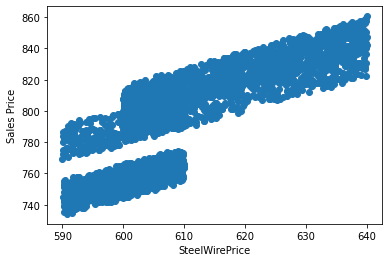

In [243]:
from matplotlib import pyplot as plt

a = df["SteelWirePrice"]
b = df["SalesPrice"]

plt.scatter(a,b)
plt.xlabel("SteelWirePrice")
plt.ylabel("Sales Price")
plt.show()

In [244]:

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


features = ["SteelWirePrice", "PowderPaintCost", "ElectricityCost", "MarketDemand", "Quantity","Profit(%)"]
x = df[features]
y= df["SalesPrice"]

df["DeliverySchedule"] = pd.to_datetime(df["DeliverySchedule"])
# Extract month from "DeliverySchedule"
df["Month"] = df["DeliverySchedule"].dt.month

#Split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

model = LinearRegression()
model.fit(x_train,y_train)

y_pred = model.predict(x_test)

#Test the model

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

coefficients = dict(zip(features, model.coef_))
intercept = model.intercept_

print("\nModel Coefficients:")
for feature, coefficient in coefficients.items():
    print(f"{feature}: {coefficient}")

print(f"intercept:{intercept}")


Mean Squared Error: 0.04191941029369173
R-squared: 0.9999286864507265

Model Coefficients:
SteelWirePrice: 1.1112686807369285
PowderPaintCost: 1.1096263362224308
ElectricityCost: 1.1103039233182235
MarketDemand: 0.2761610597507733
Quantity: 0.002161894396144351
Profit(%): 7.112350275223036
intercept:-79.00770180185668


In [245]:
average_actual_sales = df.groupby("Month")["SalesPrice"].mean()
average_predicted_sales = df.groupby("Month")["SalesPrice"].mean()

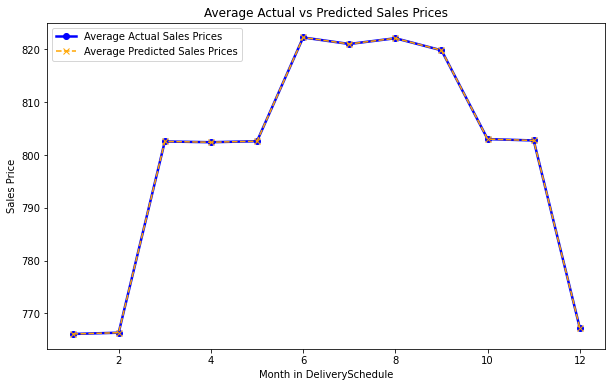

In [246]:
plt.figure(figsize=(10, 6))

plt.plot(average_actual_sales.index, average_actual_sales.values, label="Average Actual Sales Prices", color="blue", marker="o", linewidth=2.5)

# Plot average predicted sales prices in orange
plt.plot(average_predicted_sales.index, average_predicted_sales.values, label="Average Predicted Sales Prices", color="orange", linestyle="dashed", marker="x")

plt.title("Average Actual vs Predicted Sales Prices")
plt.xlabel("Month in DeliverySchedule")
plt.ylabel("Sales Price")
plt.legend()
plt.show()

In [251]:
import pandas as pd
from datetime import datetime

def calculate_sales_price(model):
    # Convert user input to DataFrame
    user_input = pd.DataFrame(columns=["SteelWirePrice", "PowderPaintCost", "ElectricityCost", "MarketDemand", "Quantity", "Profit(%)"])

    user_input.loc[0, "Quantity"] = int(input("Enter Quantity: "))
    user_input.loc[0, "SteelWirePrice"] = float(input("Enter SteelWirePrice: "))
    user_input.loc[0, "PowderPaintCost"] = float(input("Enter PowderPaintCost: "))
    user_input.loc[0, "ElectricityCost"] = float(input("Enter ElectricityCost: "))

    if 6 <= datetime.now().month <= 9 and user_input.loc[0, "Quantity"] <= 50:
        profit = 10
    elif datetime.now().month in [12, 1, 2] and user_input.loc[0, "Quantity"] > 50:
        profit = 7
    else:
        profit = 12

    if 6 <= datetime.now().month <= 9:
        marketdemand = 100
    elif datetime.now().month in [12, 1, 2]:
        marketdemand = 50
    else:
        marketdemand = 75

    user_input.loc[0, "Profit(%)"] = profit
    user_input.loc[0, "MarketDemand"] = marketdemand  # Assuming default market demand if month doesn"t match your conditions

    # Select relevant features for the model
    model_features = ["SteelWirePrice", "PowderPaintCost", "ElectricityCost", "MarketDemand", "Quantity", "Profit(%)"]

    # Calculate sales price using the provided linear regression model
    sales_price = model.predict(user_input[model_features].values.reshape(1, -1))[0]

    print("\nInput Variables:")
    for feature, value in user_input.loc[0, model_features].items():
        if feature in ["SteelWirePrice", "PowderPaintCost", "ElectricityCost"]:
            print(f"{feature}: {value:.2f} USD")
        else:
            print(f"{feature}: {value}")

    return sales_price

# Assuming "model" is defined and trained before calling this function
result = round(calculate_sales_price(model),2)
print("Output Variable")
print(f"Predicted Sales Price: {result} USD")



Input Variables:
SteelWirePrice: 625.00 USD
PowderPaintCost: 4.50 USD
ElectricityCost: 75.00 USD
MarketDemand: 50
Quantity: 150
Profit(%): 7
Output Variable
Predicted Sales Price: 767.72 USD


C:\Users\serca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
